In [2]:
# Imports 


import sys
# setting path
sys.path.append('../core')
import os
#os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

# import dfply
# from dfply import *
# import ray
# import datetime


import os
import warnings
warnings.filterwarnings("ignore")

#import torch
#torch.cuda.is_available()
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy
import pickle

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')


Bad key https in file matplotlibrc, line 2 ('https://gist.github.com/JonnyCBB/c464d302fefce4722fe6cf5f461114ea')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key https in file matplotlibrc, line 2 ('https://gist.github.com/JonnyCBB/c464d302fefce4722fe6cf5f461114ea')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.3/matplotlibrc.template
or from the matplotlib source distribution


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Simplifications to Sepsis: (1) Rewards no longer dependent on diabetes or no diabetes (averaged across them), (2) Initial state distribution now common across diabetes/no diabetes (averaged across them. But should we make this even?).

In computing the behavior policy reward, we don't use a truncated state representation. In evaluating the value estimators, we do.

In [3]:
def idx_to_trunc(state_idx, hideGlucose=True, sa=False):
    """idx_to_trunc

    The state index is determined by using "bit" arithmetic, with the
    complication that not every state is binary

    :param state_idx: Given index (720)
    
    Returns a truncated state where the "action states", 
    antibiotics, vasopressors and ventilators, are omitted
    """
    term_base = 720/3 #starts with heart rate

    # Start with the given state index
    mod_idx = state_idx

    hr_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 3
    sysbp_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 2
    percoxyg_state = np.floor(mod_idx/term_base).astype(int)

    mod_idx %= term_base
    term_base /= 5
    glucose_state = np.floor(mod_idx/term_base).astype(int)
    
    categ_num = np.array([3,3,2,5])
    state_categs = [
            hr_state,
            sysbp_state,
            percoxyg_state,
            glucose_state]
    if hideGlucose:
        mod_idx %= term_base
        term_base /= 2
        antibiotic_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vaso_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vent_state = np.floor(mod_idx/term_base).astype(int)
        categ_num = np.array([3,3,2,2,2,2])
        state_categs = [
                hr_state,
                sysbp_state,
                percoxyg_state,
                antibiotic_state,
                vaso_state,
                vent_state]
    sum_idx = 0
    prev_base = 1
    for i in range(len(state_categs)):
        idx = len(state_categs) - 1 - i
        sum_idx += prev_base*state_categs[idx]
        prev_base *= categ_num[idx]
        
    if sa:
        mod_idx %= term_base
        term_base /= 2
        antibiotic_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vaso_state = np.floor(mod_idx/term_base).astype(int)

        mod_idx %= term_base
        term_base /= 2
        vent_state = np.floor(mod_idx/term_base).astype(int)
        action = 4*antibiotic_state + 2*vaso_state + 2*vent_state
        return sum_idx, action
    else:
        return sum_idx

idx_to_trunc(719, sa=True)

(143, 0)

In [13]:
idx_to_trunc(719, sa=True)

(17, 8)

In [7]:
import mdptoolbox
vi = mdptoolbox.mdp.ValueIteration(P[1], R_sa, gamma)
vi.run()
np.array(vi.V) @ x_dist

NameError: name 'P' is not defined

In [10]:
def truncateP(P, nStates, nActions):
    truncP = np.zeros((P.shape[0], nActions, nStates, nStates)) #U, A, S, Sp
    for k in range(P.shape[0]):
        for a in tqdm(range(P.shape[1])):
            for s in range(P.shape[2]):
                for sp in range(P.shape[3]):
                    truncP[k, a, idx_to_trunc(s, hideGlucose=hideGlucose), 
                           idx_to_trunc(sp, hideGlucose=hideGlucose)] += P[k, a, s, sp]
                truncP[k, a, idx_to_trunc(s, hideGlucose=hideGlucose), 
                       idx_to_trunc(sp, hideGlucose=hideGlucose)] /= truncP[k, a, 
                                                                            idx_to_trunc(s, hideGlucose=hideGlucose), 
                                                                            idx_to_trunc(sp, hideGlucose=hideGlucose)]
    return truncP
truncP = truncateP(P, nStates, nActions)

100%|██████████| 8/8 [00:45<00:00,  5.74s/it]


In [156]:
import mdptoolbox
def getValue(Phat_ksa, Rhat_sa, startweights, priorclass, K, gamma):
    val = 0
    for k in range(K):
        vi = mdptoolbox.mdp.ValueIteration(Phat_ksa[k].transpose(1,0,2), Rhat_sa, gamma)
        vi.run()
        val += priorclass[k] * (np.array(vi.V) @ startweights[k])
    return val

#THIS IS NOT OPE. THIS IS FOR OPTIMAL POLICY ON ESTIMATED SYSTEM
getValue(modelEstims[1], Rhat_asp, startweights, priorclass, K, gamma)
#SIMULATE ESTIMATED POLICY ON ACTUAL TRUNCATED MDP TO FIND TRUE POLICY VALUE

3.7126796552802297

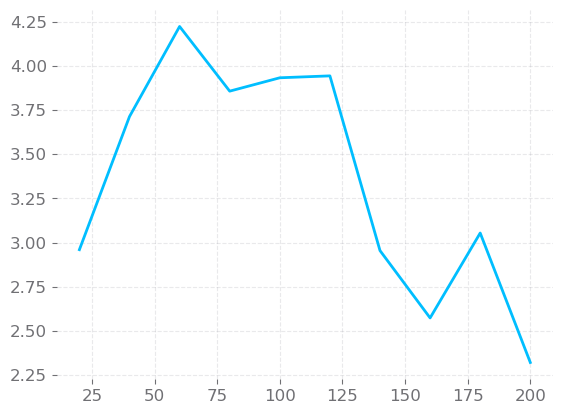

In [158]:
plt.plot(horizons,
         [getValue(modelEstims[i], Rhat_asp, 
                   startweights, priorclass, K, gamma) for i in range(len(modelEstims))])

In [12]:
d_min = np.minimum(getN_sa(dataset[dataset[:,:,2]==0], nStates, nActions, burnin=0, reshape=False)/len(dataset[dataset[:,:,2]==0]),
           getN_sa(dataset[dataset[:,:,2]==1], nStates, nActions, burnin=0, reshape=False)/len(dataset[dataset[:,:,2]==1]))


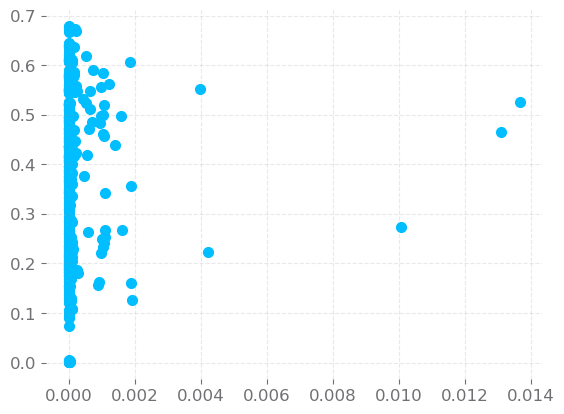

In [181]:
plt.scatter(d_min.flatten(), np.linalg.norm((truncP[0]/8)-(truncP[1]/8), axis=-1).flatten())

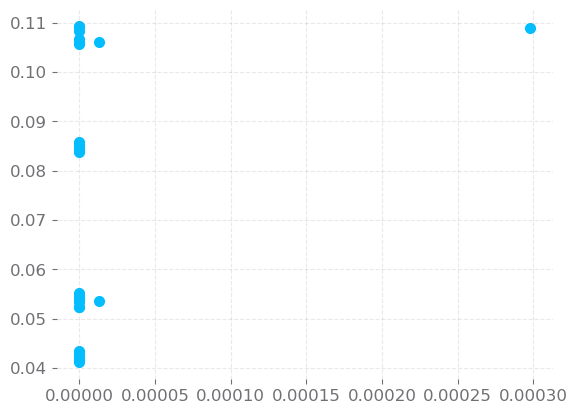

In [14]:
## GLUCOSE HIDDEN, ACTIONS NOT TRUNCATED
plt.scatter(d_min.flatten(), np.linalg.norm((truncP[0]/8)-(truncP[1]/8), axis=-1).flatten())

In [23]:
idx_to_trunc(93)

[1, 2, 1, 1, 0, 1]


93

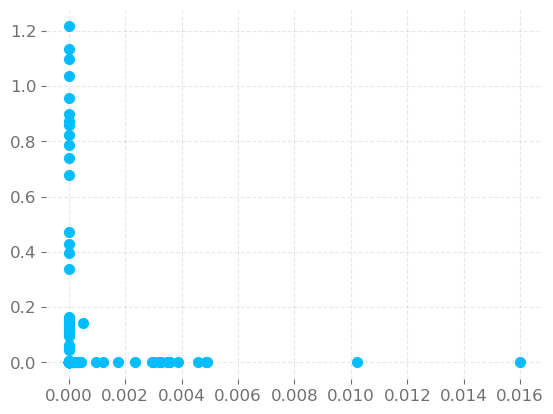

In [23]:
plt.scatter(d_min.flatten(), np.linalg.norm((truncP[0]/8)-(truncP[1]/8), axis=-1).flatten())

In [180]:
np.linalg.norm((truncP[0]/8)-(truncP[1]/8), axis=-1).flatten().shape

(720,)

In [173]:
truncP.sum(-1)/8

array([[[8., 8., 8., ..., 8., 8., 8.],
        [8., 8., 8., ..., 8., 8., 8.],
        [8., 8., 8., ..., 8., 8., 8.],
        ...,
        [8., 8., 8., ..., 8., 8., 8.],
        [8., 8., 8., ..., 8., 8., 8.],
        [8., 8., 8., ..., 8., 8., 8.]],

       [[8., 8., 8., ..., 8., 8., 8.],
        [8., 8., 8., ..., 8., 8., 8.],
        [8., 8., 8., ..., 8., 8., 8.],
        ...,
        [8., 8., 8., ..., 8., 8., 8.],
        [8., 8., 8., ..., 8., 8., 8.],
        [8., 8., 8., ..., 8., 8., 8.]]])

In [143]:
getValue(truncP.transpose(0,2,1,3)/8, Rhat_asp, startweights, u_dist, K, gamma) #THIS IS NOT OPE. THIS IS FOR OPTIMAL POLICY

1.61692525280163

In [150]:
np.linalg.norm(truncP.transpose(0,2,1,3) - Phat_ksa, axis=-1).max()

7.600129870820191

In [162]:
getValue(P.transpose(0,2,1,3), R, [x_dist, x_dist], u_dist, K, gamma)

1.7721332099823068

In [ ]:
#FOR OPE, SIMULATE 

In [122]:
np.array([getPhat(dataset[dataset[:,:,2]==0], nStates, nActions),
 getPhat(dataset[dataset[:,:,2]==1], nStates, nActions)]).sum(-1)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 1., ..., 0., 1., 1.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 1., ..., 1., 1., 1.],
        [0., 0., 1., ..., 1., 1., 0.]]])

In [ ]:
def getPhat(dataset, nStates, nActions):
    Phat = (getN_asp(dataset, nStates, nActions, reshape=False.transpose(1,0,2)/
            sa(dataset, nStates, nActions, reshape=False[...,None])
    Phat[np.isnan(Phat)] = 0
    return Phat
getValue([getPhat(dataset[dataset[:,:,2]==0], nStates, nActions),
 getPhat(dataset[dataset[:,:,2]==1], nStates, nActions)],
         Rhat_sa, startweights, priorclass, K, gamma))getN_)

StochasticError: 'PyMDPToolbox - The transition probability matrix is not stochastic.'

In [5]:
nStates

18

In [ ]:
diagnostic = False
horizons = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
#horizons = [180]

trials = 30
hideGlucose = True
import multiprocessing


clusterAccsTrials = []
clusterAccsNoProjsTrials = []
classAccsTrials = []
hardClustEMAccsTrials = []
softClustEMAccsTrials = []
hardEMAccsTrials = []
softEMAccsTrials = []

for trial in range(trials):
    clusterAccs = []
    clusterAccsNoProjs = []
    modelEstims = []
    classAccs = []
    hardClustEMs = []
    hardClustEMAccs = []
    softClustEMs = []
    softClustEMAccs = []
    hardEMs = []
    hardEMAccs = []
    softEMs = []
    softEMAccs = []
    
    start_seed = trial*multiprocessing.cpu_count()
    print("Trial", trial, "with start seed", start_seed)

    for horizon in horizons:
        print("Current Horizon is:", horizon)

        #########SETUP#########

        # Get the transition and reward matrix from file
        with open("./data/diab_txr_mats-replication.pkl", "rb") as f:
            mdict = pickle.load(f)

        envs = []

        P = mdict["tx_mat"]
        x_dist = mdict["p_initial_state"].mean(0)
        u_dist = mdict["p_mixture"]
        gamma = 0.99


        #nStates = P.shape[2]
        nActions = P.shape[1]

        R = mdict["r_mat"].mean(0)

        pi_b = np.load('data/sepsisPol.npy')
        pi_e = pi_b.mean(0)

        term = -1
        mdp = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)


        dataset = getSamplesMultiProc(500, mdp, pi_b, horizon, start_seed=start_seed, iid=False)



        for m in tqdm(range(dataset.shape[0])):
            for t in range(dataset.shape[1]):
                #s, a, u, s', r
                dataset[m,t,0] = idx_to_trunc(dataset[m,t,0], hideGlucose=hideGlucose)
                dataset[m,t,3] = idx_to_trunc(dataset[m,t,3], hideGlucose=hideGlucose)



         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())



        nStates = int(720/8) if not hideGlucose else int(720/(5))

        stateactions = dataset[:, :, [0, 1]]
        memorder = 'C'

        if memorder == 'F':
            stateactions = (dataset[:,:,0] + dataset[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
        else:
            stateactions = (dataset[:,:,0]*nActions + dataset[:,:,1]).astype(int)
        states = (dataset[:,:,0]).astype(int)
        actions = (dataset[:,:,1]).astype(int)
        currstates = dataset[:,:,[0,1]].astype(int)
        confounders = dataset[:,:,2].astype(int)
        labels = confounders[:,0].astype(int)
        nextstates = dataset[:,:,3].astype(int)

        L = 2
        K = 2
        #S = nStates*nActions
        #N = len(threes)


        ########SUBSPACE ESTIMATION########

        sadim = nStates*nActions
        spdim = nStates
        omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
        omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
        onehotsa = np.eye(sadim)[stateactions]
        #onehotsaflat = copy.deepcopy(onehotsa)
        onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
        onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
        sz = int(onehotsa.shape[0]/3)

        eigvalsa, eigvecsa = getEig(onehotsa[:sz], onehotsp[:sz], omegaone, omegatwo, K, wt=True, smalldata=False, device='/GPU:0')

        #########CLUSTERING#########

        device = "/GPU:0"

        hs = np.array([geth(onehotsa[sz:,omegaone,:,:], 
                                         onehotsp[sz:,omegaone,:]), 
                                  geth(onehotsa[sz:,omegatwo,:,:], 
                                       onehotsp[sz:,omegatwo,:])], dtype=np.float32)

        statmns = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=True)
        
        statNoProjs = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=False)
        if diagnostic:
            hi = 0.00005 if hideGlucose else 0.00012
            clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                           lo=0, hi=hi, step=0.02*hi) #0,0.01, 0.0001
            plt.show()
            clusterDiagnostics(statNoProjs, K=K, labels=confounders[sz:, 0],
                       lo=0, hi=hi, step=0.02*hi) #0,0.01, 0.0001
            plt.show()


        thresh = 2e-5 if hideGlucose else 0.00003 #0.0005
        clusterlabs = sklearn.cluster.spectral_clustering((statmns < thresh).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')

        clusterlabsNoProjs = sklearn.cluster.spectral_clustering((statNoProjs < thresh).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')

        permutation = np.argmax([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])])
        if diagnostic:
            print(permutation, np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))
        clusterAccs.append(np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))

        clusterAccsNoProjs.append(np.max([np.mean(clusterlabsNoProjs == confounders[sz:, 0]), 
                        np.mean(clusterlabsNoProjs != confounders[sz:, 0])]))

        ########MODEL ESTIMATION#########
        Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                             states[sz:,:], 
                             actions[sz:,:], 
                             nextstates[sz:,:],
                            K=K, nStates=nStates, nActions=nActions, hard=True)
        modelEstims.append(Phat_ksa)


        ########CLASSIFICATION#########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)
        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        subspaceClass = classify(Phat_ksa, states[:sz,:], actions[:sz,:], 
                               nextstates[:sz,:], piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        if diagnostic:
            print('Subspace Classification accuracy:', [np.mean(labels[:sz] == subspaceClass), 
                                                    np.mean(labels[:sz] != subspaceClass)][permutation])
        classAccs.append([np.mean(labels[:sz] == subspaceClass), np.mean(labels[:sz] != subspaceClass)][permutation])


        ########EM ALGORITHM########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)

        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        maxapos = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        mleprobs = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                            prior=priorclass, startweights = startweights, labs=False)
        if diagnostic:
            print('MAP estimate overall accuracy:', [np.mean(labels == maxapos), np.mean(labels != maxapos)][permutation])

        # HARD EM
        expectclass, modelestimclass, loglikclass = em(maxapos, 
                                Phat_ksa, states, actions, 
                            nextstates, labels=labels, 
                            K=K, nStates=nStates, nActions=nActions,
                            prior = priorclass, reg = 1, max_iter=100,
                                                   permute=False, permutation=permutation,
                                                   checkin=1, hard=True, verbose=False)
        hardClustEMs.append([expectclass, modelestimclass, loglikclass])
        hardClustEMAccs.append(np.max([np.mean(labels == expectclass), np.mean(labels != expectclass)]))

        # SOFT EM
        normprobs = np.exp(mleprobs-np.max(mleprobs))
        regprobs = 0.8*(normprobs)/np.nansum(np.abs(normprobs), 0) + 0.1*np.ones(mleprobs.shape)
        expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                                    Phat_ksa, states, actions, 
                                nextstates, labels, 
                                K=2, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 1, permute=False,
                                permutation=permutation, checkin=1, hard=False, verbose=False)
        softClustEMs.append([expectclasssoft, modelestimclasssoft, loglikclasssoft])
        softClustEMAccs.append(np.max([np.mean(labels == expectclasssoft.argmax(0)),
                                np.mean(labels != expectclasssoft.argmax(0))]))

        #############BASE EM###############

        labelsem = []
        logliksem = []
        for i in tqdm(range(30)):
            randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
            randmodel = getModelEstim(randlabs, states, actions, nextstates,
                                      K, nStates, nActions, hard=True)
            randlabs, randmodel, loglikrand = em(randlabs, randmodel,
               states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
            labelsem.append(randlabs)
            logliksem.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Hard EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem])
            plt.show()
        hardEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
        hardEMs.append([labelsem, logliksem])

        labelsemsoft = []
        logliksemsoft = []
        for i in tqdm(range(30)):
            unifs = np.random.uniform(size=len(dataset))
            randlabsoft = np.vstack([unifs, 1-unifs])
            randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                                      K, nStates, nActions, hard=False)
            randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
           states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
            labelsemsoft.append(randlabsoft)
            logliksemsoft.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
                        logliksemsoft)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            plt.ticklabel_format(style='plain',useOffset=False)
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Soft EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
            plt.show()
        softEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
        softEMs.append([labelsemsoft, logliksemsoft])
        
    clusterAccsTrials.append(clusterAccs)
    clusterAccsNoProjsTrials.append(clusterAccsNoProjs)
    classAccsTrials.append(classAccs)
    hardClustEMAccsTrials.append(hardClustEMAccs)
    softClustEMAccsTrials.append(softClustEMAccs)
    hardEMAccsTrials.append(hardEMAccs)
    softEMAccsTrials.append(softEMAccs)

Trial 0 with start seed 0
Current Horizon is: 20


100%|██████████| 480/480 [00:00<00:00, 3585.55it/s]


value of pi_b
0.4876657099979267


2023-01-19 20:07:24.483856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 20:07:24.484890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 20:07:24.485013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 20:07:24.485060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1769.87it/s]


value of pi_b
0.8339380091389029


100%|██████████| 30/30 [00:02<00:00, 10.59it/s]


Current Horizon is: 60


100%|██████████| 480/480 [00:00<00:00, 1169.33it/s]


value of pi_b
0.8419774049489097


100%|██████████| 30/30 [00:02<00:00, 13.72it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 874.47it/s]


value of pi_b
0.6758130170119824


100%|██████████| 30/30 [00:02<00:00, 13.18it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 711.88it/s]


value of pi_b
0.913295169385248


100%|██████████| 30/30 [00:02<00:00, 13.99it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 586.28it/s]


value of pi_b
0.82565655234993


100%|██████████| 30/30 [00:02<00:00, 12.30it/s]


Current Horizon is: 140


100%|██████████| 480/480 [00:00<00:00, 502.38it/s]


value of pi_b
0.8635321245885919


100%|██████████| 30/30 [00:02<00:00, 12.59it/s]

Current Horizon is: 160



100%|██████████| 480/480 [00:01<00:00, 443.50it/s]


value of pi_b
0.7526542175804882


100%|██████████| 30/30 [00:02<00:00, 13.24it/s]

Current Horizon is: 180



100%|██████████| 480/480 [00:01<00:00, 394.95it/s]


value of pi_b
0.804087788323491


100%|██████████| 30/30 [00:01<00:00, 16.19it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 355.82it/s]


value of pi_b
0.513344874958257


100%|██████████| 30/30 [00:02<00:00, 13.92it/s]

Trial 1 with start seed 32
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3581.46it/s]


value of pi_b
0.5086687742665084


100%|██████████| 30/30 [00:03<00:00,  9.10it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1769.02it/s]


value of pi_b
0.7197216321942984


100%|██████████| 30/30 [00:02<00:00, 11.18it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1180.90it/s]


value of pi_b
0.8561070339080231


100%|██████████| 30/30 [00:01<00:00, 16.38it/s]


Current Horizon is: 80


100%|██████████| 480/480 [00:00<00:00, 886.51it/s]


value of pi_b
0.886263984583924


100%|██████████| 30/30 [00:02<00:00, 12.16it/s]


Current Horizon is: 100


100%|██████████| 480/480 [00:00<00:00, 717.58it/s]


value of pi_b
1.0058290530415848


100%|██████████| 30/30 [00:01<00:00, 15.67it/s]


Current Horizon is: 120


100%|██████████| 480/480 [00:00<00:00, 581.08it/s]


value of pi_b
0.7927044420025593


100%|██████████| 30/30 [00:01<00:00, 15.93it/s]


Current Horizon is: 140


100%|██████████| 480/480 [00:00<00:00, 509.73it/s]


value of pi_b
0.8801140758837749


100%|██████████| 30/30 [00:01<00:00, 17.39it/s]


Current Horizon is: 160


100%|██████████| 480/480 [00:01<00:00, 443.72it/s]


value of pi_b
0.7550872526239959


100%|██████████| 30/30 [00:02<00:00, 13.83it/s]

Current Horizon is: 180



100%|██████████| 480/480 [00:01<00:00, 395.03it/s]


value of pi_b
0.9446325366547487


100%|██████████| 30/30 [00:03<00:00,  9.07it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 355.13it/s]


value of pi_b
0.7248096023984438


100%|██████████| 30/30 [00:02<00:00, 10.00it/s]

Trial 2 with start seed 64
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3593.03it/s]


value of pi_b
0.4791927382338803


100%|██████████| 30/30 [00:04<00:00,  6.87it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1711.06it/s]


value of pi_b
0.6530191162202885


100%|██████████| 30/30 [00:02<00:00, 10.92it/s]


Current Horizon is: 60


100%|██████████| 480/480 [00:00<00:00, 1174.18it/s]


value of pi_b
0.8779133285183216


100%|██████████| 30/30 [00:02<00:00, 14.18it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 891.09it/s]


value of pi_b
0.4918206379525912


100%|██████████| 30/30 [00:02<00:00, 13.37it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 704.02it/s]


value of pi_b
0.5224538271857609


100%|██████████| 30/30 [00:01<00:00, 16.33it/s]


Current Horizon is: 120


100%|██████████| 480/480 [00:00<00:00, 583.99it/s]


value of pi_b
0.714727358737084


100%|██████████| 30/30 [00:02<00:00, 11.20it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:00<00:00, 507.10it/s]


value of pi_b
0.7968428008016628


100%|██████████| 30/30 [00:02<00:00, 13.12it/s]

Current Horizon is: 160



100%|██████████| 480/480 [00:01<00:00, 441.29it/s]


value of pi_b
0.5672111909578992


100%|██████████| 30/30 [00:02<00:00, 11.88it/s]


Current Horizon is: 180


100%|██████████| 480/480 [00:01<00:00, 390.11it/s]


value of pi_b
0.7199120050998881


100%|██████████| 30/30 [00:02<00:00, 10.88it/s]


Current Horizon is: 200


100%|██████████| 480/480 [00:01<00:00, 357.02it/s]


value of pi_b
0.7831847121294834


100%|██████████| 30/30 [00:02<00:00, 11.92it/s]

Trial 3 with start seed 96
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3582.67it/s]


value of pi_b
0.5487395255742161


100%|██████████| 30/30 [00:03<00:00,  8.58it/s]


Current Horizon is: 40


100%|██████████| 480/480 [00:00<00:00, 1763.22it/s]


value of pi_b
0.6279838379186745


100%|██████████| 30/30 [00:02<00:00, 13.10it/s]


Current Horizon is: 60


100%|██████████| 480/480 [00:00<00:00, 1173.45it/s]


value of pi_b
0.7765734480097559


100%|██████████| 30/30 [00:01<00:00, 16.46it/s]


Current Horizon is: 80


100%|██████████| 480/480 [00:00<00:00, 883.61it/s]


value of pi_b
0.668420659941809


100%|██████████| 30/30 [00:01<00:00, 15.91it/s]


Current Horizon is: 100


100%|██████████| 480/480 [00:00<00:00, 705.81it/s]


value of pi_b
0.6421456433353391


100%|██████████| 30/30 [00:01<00:00, 15.41it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 593.34it/s]


value of pi_b
0.659223009894777


100%|██████████| 30/30 [00:02<00:00, 12.32it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:00<00:00, 502.64it/s]


value of pi_b
0.5164771686965367


100%|██████████| 30/30 [00:01<00:00, 17.54it/s]


Current Horizon is: 160


100%|██████████| 480/480 [00:01<00:00, 442.37it/s]


value of pi_b
0.7310439345070103


100%|██████████| 30/30 [00:02<00:00, 14.00it/s]


Current Horizon is: 180


100%|██████████| 480/480 [00:01<00:00, 393.37it/s]


value of pi_b
0.7926558044273758


100%|██████████| 30/30 [00:01<00:00, 15.38it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 354.53it/s]


value of pi_b
0.5790781676080523


100%|██████████| 30/30 [00:02<00:00, 11.16it/s]

Trial 4 with start seed 128
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3558.74it/s]


value of pi_b
0.4533890063537236


100%|██████████| 30/30 [00:04<00:00,  7.44it/s]


Current Horizon is: 40


100%|██████████| 480/480 [00:00<00:00, 1790.77it/s]


value of pi_b
0.560575772742078


100%|██████████| 30/30 [00:03<00:00,  9.08it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1173.60it/s]


value of pi_b
0.669099755459622


100%|██████████| 30/30 [00:02<00:00, 12.33it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 877.80it/s]


value of pi_b
0.6776746318259287


100%|██████████| 30/30 [00:01<00:00, 15.59it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 706.35it/s]


value of pi_b
0.7755769284403989


100%|██████████| 30/30 [00:02<00:00, 11.19it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 581.64it/s]


value of pi_b
0.6396557238392794


100%|██████████| 30/30 [00:02<00:00, 13.95it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:00<00:00, 508.61it/s]


value of pi_b
0.693262417444286


100%|██████████| 30/30 [00:02<00:00, 13.90it/s]

Current Horizon is: 160



100%|██████████| 480/480 [00:01<00:00, 451.28it/s]


value of pi_b
0.9062081298972765


100%|██████████| 30/30 [00:02<00:00, 11.68it/s]

Current Horizon is: 180



100%|██████████| 480/480 [00:01<00:00, 391.45it/s]


value of pi_b
0.39222298487995577


100%|██████████| 30/30 [00:02<00:00, 13.73it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 353.21it/s]


value of pi_b
0.6672518949269484


100%|██████████| 30/30 [00:02<00:00, 10.39it/s]


Trial 5 with start seed 160
Current Horizon is: 20


100%|██████████| 480/480 [00:00<00:00, 3492.20it/s]


value of pi_b
0.4534153694211981


100%|██████████| 30/30 [00:03<00:00,  8.55it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1769.93it/s]


value of pi_b
0.3725616644482755


100%|██████████| 30/30 [00:02<00:00, 11.92it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1186.60it/s]


value of pi_b
0.8295241031994982


100%|██████████| 30/30 [00:02<00:00, 12.98it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 886.38it/s]


value of pi_b
0.6895577292755237


100%|██████████| 30/30 [00:02<00:00, 12.64it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 703.02it/s]


value of pi_b
0.6755185198628912


100%|██████████| 30/30 [00:02<00:00, 12.23it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 591.52it/s]


value of pi_b
0.6471459601371577


100%|██████████| 30/30 [00:02<00:00, 11.67it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:00<00:00, 505.30it/s]


value of pi_b
0.7466499725165144


100%|██████████| 30/30 [00:02<00:00, 12.35it/s]

Current Horizon is: 160



100%|██████████| 480/480 [00:01<00:00, 449.07it/s]


value of pi_b
0.44403509833531357


100%|██████████| 30/30 [00:02<00:00, 11.21it/s]


Current Horizon is: 180


100%|██████████| 480/480 [00:01<00:00, 394.78it/s]


value of pi_b
0.6734322485437673


100%|██████████| 30/30 [00:02<00:00, 12.32it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 356.09it/s]


value of pi_b
0.7407105704787388


100%|██████████| 30/30 [00:02<00:00, 14.00it/s]

Trial 6 with start seed 192
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3541.42it/s]


value of pi_b
0.4421688301079455


100%|██████████| 30/30 [00:02<00:00, 10.65it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1789.42it/s]


value of pi_b
0.6400371232794341


100%|██████████| 30/30 [00:02<00:00, 13.10it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1132.51it/s]


value of pi_b
0.8299589588568748


100%|██████████| 30/30 [00:02<00:00, 14.43it/s]


Current Horizon is: 80


100%|██████████| 480/480 [00:00<00:00, 881.50it/s]


value of pi_b
0.48422306420767086


100%|██████████| 30/30 [00:02<00:00, 12.55it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 706.68it/s]


value of pi_b
0.7744356335937136


100%|██████████| 30/30 [00:03<00:00,  9.58it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 584.42it/s]


value of pi_b
0.7956903203945274


100%|██████████| 30/30 [00:02<00:00, 11.79it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:01<00:00, 473.12it/s]


value of pi_b
0.7047939669117939


100%|██████████| 30/30 [00:02<00:00, 13.93it/s]


Current Horizon is: 160


100%|██████████| 480/480 [00:01<00:00, 435.30it/s]


value of pi_b
0.8075342713658825


100%|██████████| 30/30 [00:02<00:00, 13.28it/s]

Current Horizon is: 180



100%|██████████| 480/480 [00:01<00:00, 383.78it/s]


value of pi_b
0.9139763545435213


100%|██████████| 30/30 [00:02<00:00, 11.86it/s]


Current Horizon is: 200


100%|██████████| 480/480 [00:01<00:00, 352.44it/s]


value of pi_b
0.5028321692405543


100%|██████████| 30/30 [00:02<00:00, 10.40it/s]

Trial 7 with start seed 224
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3523.83it/s]


value of pi_b
0.42578198121597965


100%|██████████| 30/30 [00:03<00:00,  8.87it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1771.93it/s]


value of pi_b
0.5207742783513781


100%|██████████| 30/30 [00:02<00:00, 13.44it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1174.59it/s]


value of pi_b
0.847908900968301


100%|██████████| 30/30 [00:01<00:00, 16.19it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 874.40it/s]


value of pi_b
0.8346611821487764


100%|██████████| 30/30 [00:02<00:00, 14.94it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 692.00it/s]


value of pi_b
0.770982596917127


100%|██████████| 30/30 [00:02<00:00, 11.93it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 589.93it/s]


value of pi_b
0.9259134038915495


100%|██████████| 30/30 [00:02<00:00, 14.17it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:00<00:00, 498.19it/s]


value of pi_b
0.6747222873765817


100%|██████████| 30/30 [00:01<00:00, 15.42it/s]


Current Horizon is: 160


100%|██████████| 480/480 [00:01<00:00, 443.04it/s]


value of pi_b
0.7136489206286203


100%|██████████| 30/30 [00:02<00:00, 14.91it/s]

Current Horizon is: 180



100%|██████████| 480/480 [00:01<00:00, 388.50it/s]


value of pi_b
0.7334849367997668


100%|██████████| 30/30 [00:02<00:00, 13.42it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 352.20it/s]


value of pi_b
0.9932929838927194


100%|██████████| 30/30 [00:02<00:00, 11.52it/s]

Trial 8 with start seed 256
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3494.22it/s]


value of pi_b
0.2880065538313506


100%|██████████| 30/30 [00:04<00:00,  6.46it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1169.62it/s]


value of pi_b
0.6711869528042581


100%|██████████| 30/30 [00:01<00:00, 15.46it/s]


Current Horizon is: 60


100%|██████████| 480/480 [00:00<00:00, 1183.13it/s]


value of pi_b
0.7509104452165839


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 890.54it/s]


value of pi_b
0.859036371342827


100%|██████████| 30/30 [00:03<00:00,  8.25it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 701.28it/s]


value of pi_b
0.7450619962689288


100%|██████████| 30/30 [00:02<00:00, 13.68it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 570.31it/s]


value of pi_b
0.8013974618448922


100%|██████████| 30/30 [00:02<00:00, 12.75it/s]


Current Horizon is: 140


100%|██████████| 480/480 [00:00<00:00, 482.04it/s]


value of pi_b
0.5708643913885283


100%|██████████| 30/30 [00:02<00:00, 12.85it/s]

Current Horizon is: 160



100%|██████████| 480/480 [00:01<00:00, 437.13it/s]


value of pi_b
0.6275670779265557


100%|██████████| 30/30 [00:03<00:00,  8.16it/s]


Current Horizon is: 180


100%|██████████| 480/480 [00:01<00:00, 387.27it/s]


value of pi_b
0.8400654278043583


100%|██████████| 30/30 [00:03<00:00,  9.66it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 345.59it/s]


value of pi_b
0.6730568065814909


100%|██████████| 30/30 [00:02<00:00, 10.48it/s]

Trial 9 with start seed 288
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3500.68it/s]


value of pi_b
0.45201254012713116


100%|██████████| 30/30 [00:03<00:00,  8.06it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1706.19it/s]


value of pi_b
0.5956403499988554


100%|██████████| 30/30 [00:02<00:00, 12.26it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1171.32it/s]


value of pi_b
0.708875781639758


100%|██████████| 30/30 [00:01<00:00, 17.93it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 871.87it/s]


value of pi_b
0.7555070134203277


100%|██████████| 30/30 [00:02<00:00, 11.84it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 698.69it/s]


value of pi_b
0.848073959499589


100%|██████████| 30/30 [00:01<00:00, 15.48it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 583.04it/s]


value of pi_b
0.7017118770240262


100%|██████████| 30/30 [00:02<00:00, 11.93it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:00<00:00, 501.08it/s]


value of pi_b
0.8122925379153298


100%|██████████| 30/30 [00:01<00:00, 15.02it/s]


Current Horizon is: 160


100%|██████████| 480/480 [00:01<00:00, 440.46it/s]


value of pi_b
0.8361074334388461


100%|██████████| 30/30 [00:02<00:00, 14.69it/s]


Current Horizon is: 180


100%|██████████| 480/480 [00:01<00:00, 389.50it/s]


value of pi_b
0.6404215970413593


100%|██████████| 30/30 [00:02<00:00, 11.62it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 350.53it/s]


value of pi_b
0.9514180261706094


100%|██████████| 30/30 [00:02<00:00, 14.17it/s]

Trial 10 with start seed 320
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3504.04it/s]


value of pi_b
0.5812086531703983


100%|██████████| 30/30 [00:04<00:00,  6.30it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1785.09it/s]


value of pi_b
0.6402621171870398


100%|██████████| 30/30 [00:02<00:00, 12.99it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1172.62it/s]


value of pi_b
0.8935346460310253


100%|██████████| 30/30 [00:02<00:00, 12.72it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 874.25it/s]


value of pi_b
0.8068073698749328


100%|██████████| 30/30 [00:02<00:00, 13.03it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 698.04it/s]


value of pi_b
0.8178288826101224


100%|██████████| 30/30 [00:02<00:00, 14.22it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 579.16it/s]


value of pi_b
0.6870040602970152


100%|██████████| 30/30 [00:02<00:00, 12.04it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:00<00:00, 502.68it/s]


value of pi_b
0.672416700043739


100%|██████████| 30/30 [00:02<00:00, 12.20it/s]

Current Horizon is: 160



100%|██████████| 480/480 [00:01<00:00, 436.28it/s]


value of pi_b
0.6930465104151114


100%|██████████| 30/30 [00:02<00:00, 14.01it/s]

Current Horizon is: 180



100%|██████████| 480/480 [00:01<00:00, 390.89it/s]


value of pi_b
0.697169782874655


100%|██████████| 30/30 [00:02<00:00, 12.35it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 351.20it/s]


value of pi_b
1.0275915230558716


100%|██████████| 30/30 [00:02<00:00, 13.50it/s]


Trial 11 with start seed 352
Current Horizon is: 20


100%|██████████| 480/480 [00:00<00:00, 3451.74it/s]


value of pi_b
0.3446177659559339


100%|██████████| 30/30 [00:04<00:00,  7.09it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1737.50it/s]


value of pi_b
0.5096338746292425


100%|██████████| 30/30 [00:02<00:00, 10.56it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1162.31it/s]


value of pi_b
0.8462147748696192


100%|██████████| 30/30 [00:02<00:00, 14.46it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 864.64it/s]


value of pi_b
0.606357785026335


100%|██████████| 30/30 [00:02<00:00, 14.41it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 695.54it/s]


value of pi_b
0.6119744638683946


100%|██████████| 30/30 [00:02<00:00, 12.62it/s]


Current Horizon is: 120


100%|██████████| 480/480 [00:00<00:00, 580.14it/s]


value of pi_b
0.6290210594789906


100%|██████████| 30/30 [00:02<00:00, 13.30it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:00<00:00, 496.16it/s]


value of pi_b
0.6591775412699721


100%|██████████| 30/30 [00:02<00:00, 14.85it/s]

Current Horizon is: 160



100%|██████████| 480/480 [00:01<00:00, 434.95it/s]


value of pi_b
0.6670823315235275


100%|██████████| 30/30 [00:02<00:00, 14.52it/s]

Current Horizon is: 180



100%|██████████| 480/480 [00:01<00:00, 391.92it/s]


value of pi_b
0.5815570373474058


100%|██████████| 30/30 [00:02<00:00, 13.76it/s]


Current Horizon is: 200


100%|██████████| 480/480 [00:01<00:00, 352.79it/s]


value of pi_b
0.7825470740265985


100%|██████████| 30/30 [00:02<00:00, 12.56it/s]

Trial 12 with start seed 384
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3534.78it/s]


value of pi_b
0.3912627227725977


100%|██████████| 30/30 [00:03<00:00,  7.57it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1706.14it/s]


value of pi_b
0.6074940750793654


100%|██████████| 30/30 [00:03<00:00,  9.86it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1177.86it/s]


value of pi_b
0.7409088454901379


100%|██████████| 30/30 [00:02<00:00, 12.20it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 877.18it/s]


value of pi_b
0.8118486166374969


100%|██████████| 30/30 [00:02<00:00, 12.47it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 698.25it/s]


value of pi_b
0.8738841111486669


100%|██████████| 30/30 [00:02<00:00, 13.35it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 589.46it/s]


value of pi_b
0.8598737030709205


100%|██████████| 30/30 [00:02<00:00, 13.53it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:00<00:00, 504.45it/s]


value of pi_b
0.8393048661654575


100%|██████████| 30/30 [00:02<00:00, 13.47it/s]


Current Horizon is: 160


100%|██████████| 480/480 [00:01<00:00, 437.35it/s]


value of pi_b
0.6212732421186385


100%|██████████| 30/30 [00:02<00:00, 12.77it/s]

Current Horizon is: 180



100%|██████████| 480/480 [00:01<00:00, 391.76it/s]


value of pi_b
0.7218356034291491


100%|██████████| 30/30 [00:02<00:00, 10.52it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 352.07it/s]


value of pi_b
0.6277250053967397


100%|██████████| 30/30 [00:03<00:00,  9.52it/s]

Trial 13 with start seed 416
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3501.32it/s]


value of pi_b
0.5181762765203634


100%|██████████| 30/30 [00:04<00:00,  6.93it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1666.85it/s]


value of pi_b
0.8336403168474935


100%|██████████| 30/30 [00:02<00:00, 11.96it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1173.76it/s]


value of pi_b
0.8820822718934276


100%|██████████| 30/30 [00:01<00:00, 15.04it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 854.18it/s]


value of pi_b
0.8770871472800933


100%|██████████| 30/30 [00:01<00:00, 15.98it/s]


Current Horizon is: 100


100%|██████████| 480/480 [00:00<00:00, 698.76it/s]


value of pi_b
1.046380641198176


100%|██████████| 30/30 [00:02<00:00, 14.48it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 590.03it/s]


value of pi_b
0.8585614446851727


100%|██████████| 30/30 [00:02<00:00, 11.80it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:00<00:00, 506.04it/s]


value of pi_b
0.7158406142583842


100%|██████████| 30/30 [00:02<00:00, 13.33it/s]

Current Horizon is: 160



100%|██████████| 480/480 [00:01<00:00, 434.90it/s]


value of pi_b
0.8365621189697917


100%|██████████| 30/30 [00:02<00:00, 14.91it/s]


Current Horizon is: 180


100%|██████████| 480/480 [00:01<00:00, 387.02it/s]


value of pi_b
0.9274602974072257


100%|██████████| 30/30 [00:02<00:00, 11.46it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 343.08it/s]


value of pi_b
0.9548239065884031


100%|██████████| 30/30 [00:02<00:00, 10.23it/s]

Trial 14 with start seed 448
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3440.39it/s]


value of pi_b
0.4561351028389426


100%|██████████| 30/30 [00:04<00:00,  7.23it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1752.69it/s]


value of pi_b
0.7252805978456766


100%|██████████| 30/30 [00:02<00:00, 12.24it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1136.04it/s]


value of pi_b
0.6688980851040022


100%|██████████| 30/30 [00:02<00:00, 10.35it/s]


Current Horizon is: 80


100%|██████████| 480/480 [00:00<00:00, 873.14it/s]


value of pi_b
0.7538889143202262


100%|██████████| 30/30 [00:01<00:00, 18.35it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 705.39it/s]


value of pi_b
0.8912701189988564


100%|██████████| 30/30 [00:02<00:00, 14.90it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 581.70it/s]


value of pi_b
0.8346776451273852


100%|██████████| 30/30 [00:01<00:00, 15.39it/s]


Current Horizon is: 140


100%|██████████| 480/480 [00:00<00:00, 495.63it/s]


value of pi_b
0.7847404378086082


100%|██████████| 30/30 [00:02<00:00, 14.56it/s]

Current Horizon is: 160



100%|██████████| 480/480 [00:01<00:00, 437.83it/s]


value of pi_b
0.528507975728371


100%|██████████| 30/30 [00:02<00:00, 10.70it/s]

Current Horizon is: 180



100%|██████████| 480/480 [00:01<00:00, 389.78it/s]


value of pi_b
0.6825264473260939


100%|██████████| 30/30 [00:02<00:00, 10.53it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 352.77it/s]


value of pi_b
0.7853225502534041


100%|██████████| 30/30 [00:03<00:00,  8.75it/s]

Trial 15 with start seed 480
Current Horizon is: 20



100%|██████████| 480/480 [00:00<00:00, 3506.86it/s]


value of pi_b
0.4566386454536918


100%|██████████| 30/30 [00:03<00:00,  8.91it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1739.68it/s]


value of pi_b
0.542003522382602


100%|██████████| 30/30 [00:02<00:00, 11.11it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1159.75it/s]


value of pi_b
0.5803120445849322


100%|██████████| 30/30 [00:02<00:00, 11.70it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 883.61it/s]


value of pi_b
0.7132332790445065


100%|██████████| 30/30 [00:02<00:00, 14.33it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 697.06it/s]


value of pi_b
0.7276776191483803


100%|██████████| 30/30 [00:02<00:00, 13.01it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 575.39it/s]


value of pi_b
0.7529171639855555


100%|██████████| 30/30 [00:02<00:00, 13.14it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:00<00:00, 500.23it/s]


value of pi_b
0.6631834133337919


100%|██████████| 30/30 [00:02<00:00, 12.82it/s]


Current Horizon is: 160


100%|██████████| 480/480 [00:01<00:00, 434.81it/s]


value of pi_b
0.5729073001261987


100%|██████████| 30/30 [00:02<00:00, 10.37it/s]

Current Horizon is: 180



100%|██████████| 480/480 [00:01<00:00, 395.01it/s]


value of pi_b
0.43340388687587805


100%|██████████| 30/30 [00:02<00:00, 13.91it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 352.20it/s]


value of pi_b
0.8829898338098464


100%|██████████| 30/30 [00:02<00:00, 13.93it/s]


Trial 16 with start seed 512
Current Horizon is: 20


100%|██████████| 480/480 [00:00<00:00, 3480.79it/s]


value of pi_b
0.5510978097248208


100%|██████████| 30/30 [00:03<00:00,  8.11it/s]

Current Horizon is: 40



100%|██████████| 480/480 [00:00<00:00, 1785.64it/s]


value of pi_b
0.7138258431664712


100%|██████████| 30/30 [00:02<00:00, 10.48it/s]

Current Horizon is: 60



100%|██████████| 480/480 [00:00<00:00, 1101.11it/s]


value of pi_b
0.6308358605102058


100%|██████████| 30/30 [00:02<00:00, 13.36it/s]

Current Horizon is: 80



100%|██████████| 480/480 [00:00<00:00, 872.95it/s]


value of pi_b
0.8425130849845675


100%|██████████| 30/30 [00:02<00:00, 13.13it/s]

Current Horizon is: 100



100%|██████████| 480/480 [00:00<00:00, 705.77it/s]


value of pi_b
0.7942012936514627


100%|██████████| 30/30 [00:02<00:00, 12.98it/s]

Current Horizon is: 120



100%|██████████| 480/480 [00:00<00:00, 581.85it/s]


value of pi_b
0.6059919639425181


100%|██████████| 30/30 [00:02<00:00, 11.52it/s]

Current Horizon is: 140



100%|██████████| 480/480 [00:00<00:00, 500.80it/s]


value of pi_b
0.7885681779577699


100%|██████████| 30/30 [00:03<00:00,  9.75it/s]


Current Horizon is: 160


100%|██████████| 480/480 [00:01<00:00, 446.32it/s]


value of pi_b
0.9026300690959909


100%|██████████| 30/30 [00:02<00:00, 12.71it/s]

Current Horizon is: 180



100%|██████████| 480/480 [00:01<00:00, 389.29it/s]


value of pi_b
0.765072542633313


100%|██████████| 30/30 [00:02<00:00, 11.50it/s]

Current Horizon is: 200



100%|██████████| 480/480 [00:01<00:00, 351.03it/s]


value of pi_b
0.5119108101569989


100%|██████████| 30/30 [00:02<00:00, 12.86it/s]


Trial 17 with start seed 544
Current Horizon is: 20


In [ ]:
#try hidden glucose and actions in state space

In [37]:
np.array(clusterAccs)

array([0.771875, 0.984375])

In [1]:
np.array(clusterAccsNoProjs)

NameError: name 'np' is not defined

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.mean(np.array(clusterAccsTrials),0), label='With Subspace')
plt.plot(horizons, 1-np.mean(np.array(clusterAccsNoProjsTrials),0), label='Clustering Error No Subspace')
plt.ylabel("Clustering Error")
plt.xlabel("Trajectory Length")
plt.title("Clustering Error vs Trajectory Length, Sepsis")
plt.legend()

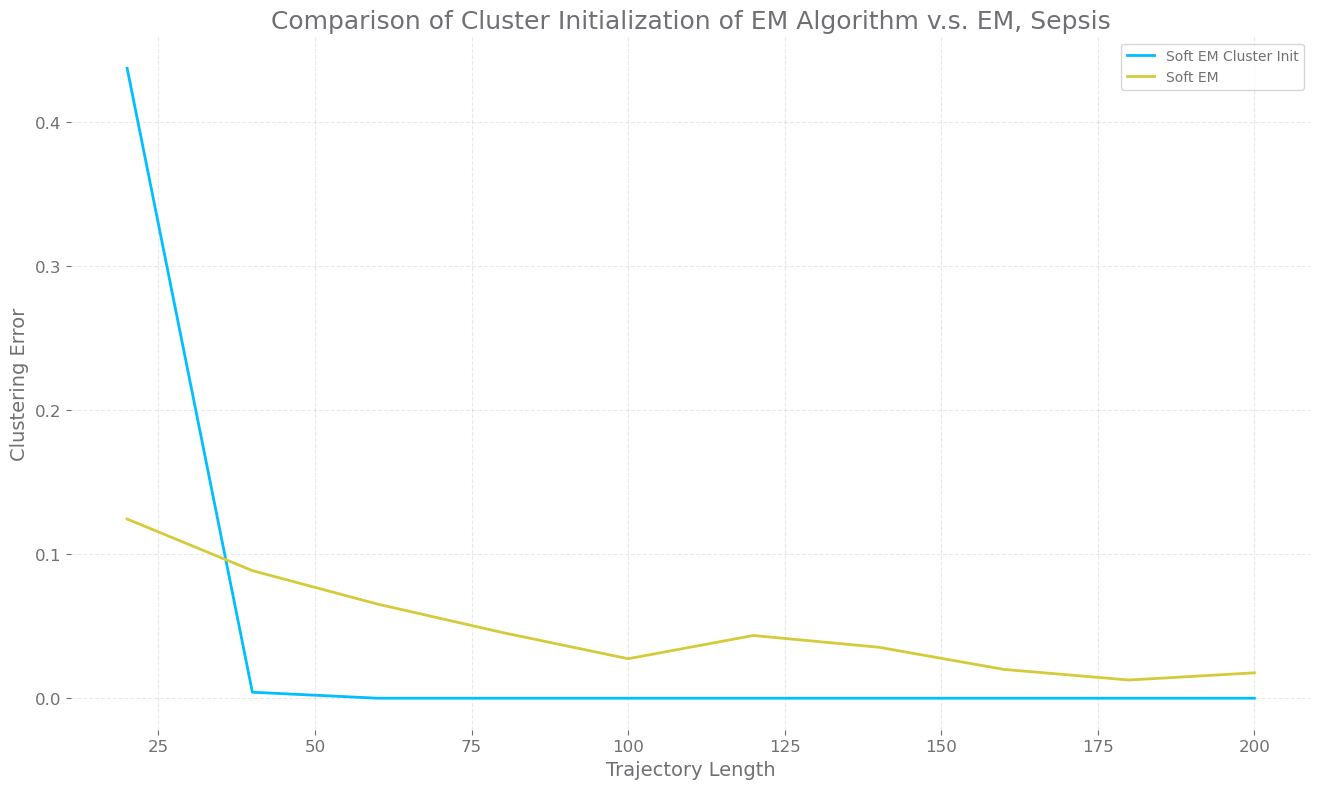

In [9]:
plt.figure(figsize=(16,9))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''       
plt.plot(horizons, 1-np.mean(np.array(softClustEMAccsTrials),0),
         label='Soft EM Cluster Init')
plt.plot(horizons, 1-np.mean(np.array(softEMAccsTrials),0),
        label='Soft EM')
plt.ylabel("Clustering Error")
plt.xlabel("Trajectory Length")
plt.title("Comparison of Cluster Initialization of EM Algorithm v.s. EM, Sepsis")
plt.legend()

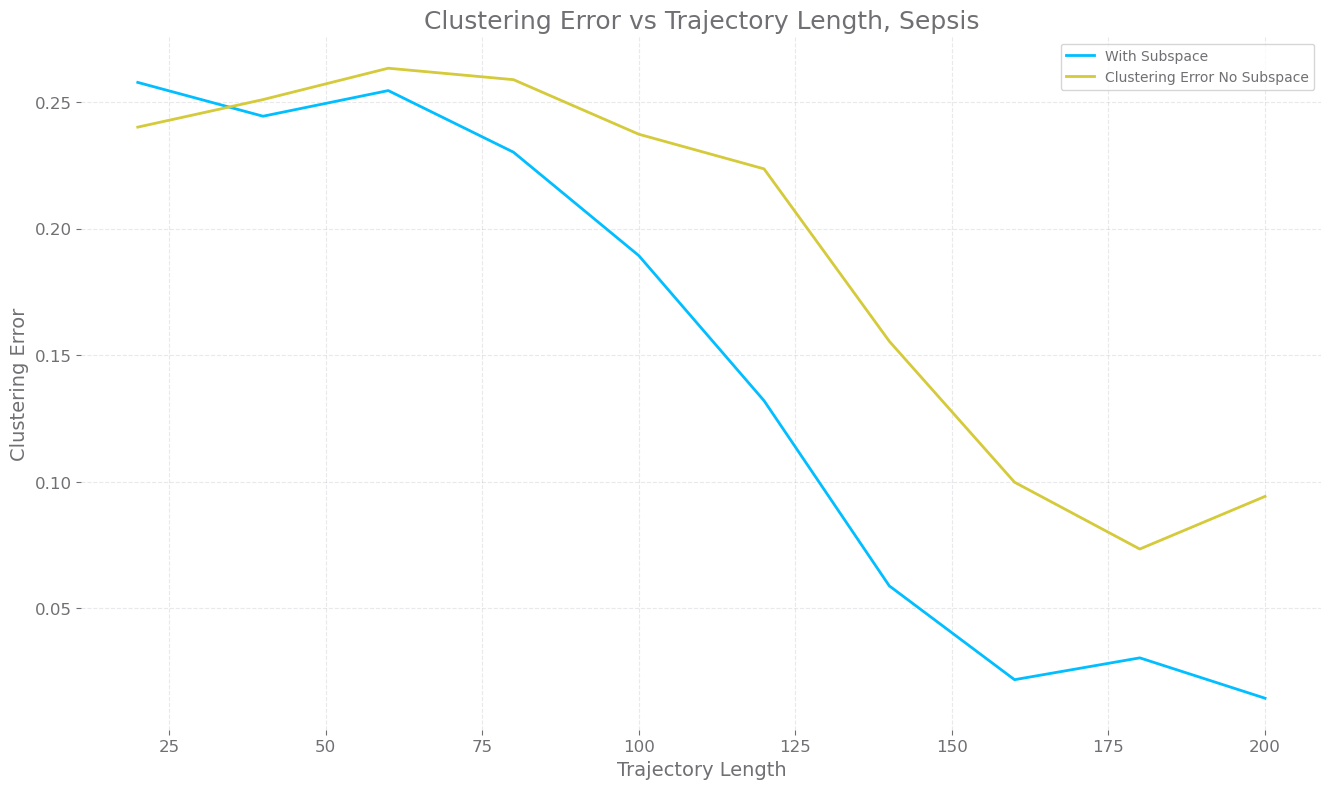

In [5]:
plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.mean(np.array(clusterAccsTrials),0), label='With Subspace')
plt.plot(horizons, 1-np.mean(np.array(clusterAccsNoProjsTrials),0), label='Clustering Error No Subspace')
plt.ylabel("Clustering Error")
plt.xlabel("Trajectory Length")
plt.title("Clustering Error vs Trajectory Length, Sepsis")
plt.legend()

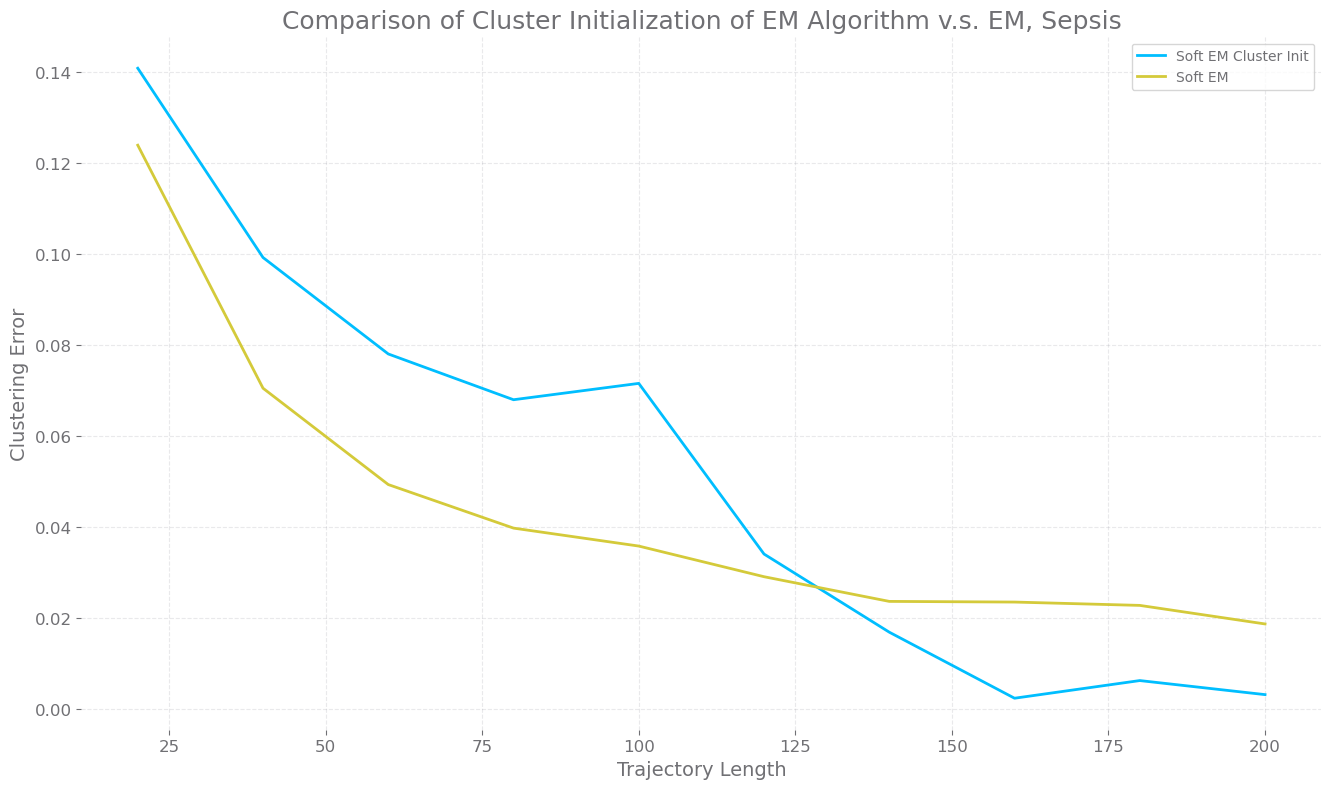

In [7]:
plt.figure(figsize=(16,9))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''       
plt.plot(horizons, 1-np.mean(np.array(softClustEMAccsTrials),0),
         label='Soft EM Cluster Init')
plt.plot(horizons, 1-np.mean(np.array(softEMAccsTrials),0),
        label='Soft EM')
plt.ylabel("Clustering Error")
plt.xlabel("Trajectory Length")
plt.title("Comparison of Cluster Initialization of EM Algorithm v.s. EM, Sepsis")
plt.legend()

In [47]:
Rhat_sa = getR_sa(dataset, nStates, nActions)
Rhat_asp = getR_asp(dataset, nStates, nActions)

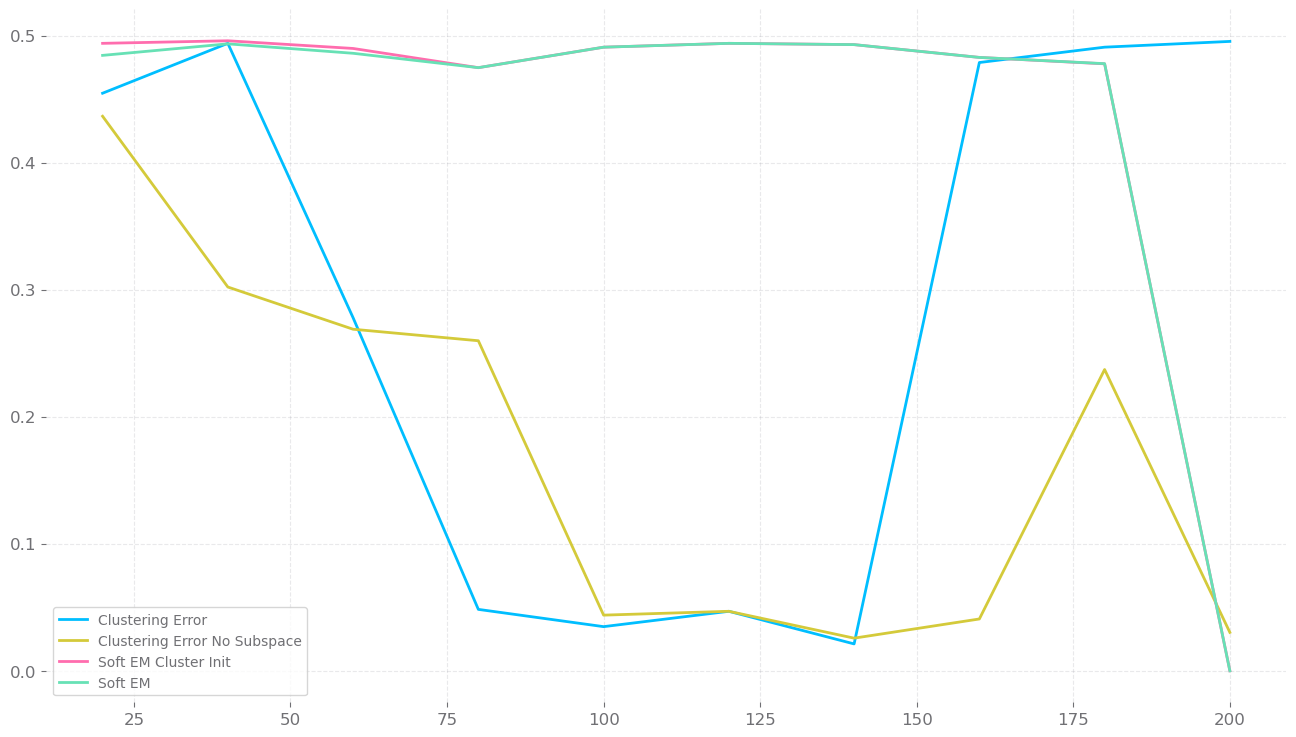

In [7]:
plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.array(clusterAccs), label='Clustering Error')
plt.plot(horizons, 1-np.array(clusterAccsNoProjs), label='Clustering Error No Subspace')
'''
plt.plot(horizons, 1-np.array(classAccs), label='Subspace Classification')
plt.plot(horizons, 1-np.array([np.max([np.mean(i[0]==labels), 
                  np.mean(i[0]!=labels)]) for i in hardClustEMs]),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.array([np.mean([np.max([np.mean(j.argmax(0)==labels), np.mean(j.argmax(0)!=labels)]) 
  for j in hardEMs[i][0]]) for i in range(len(hardEMs))]),
        label='Hard EM')
'''
plt.plot(horizons, 1-np.array([np.max([np.mean(np.argmax(i[0],0)==labels), 
                  np.mean(np.argmax(i[0],0)!=labels)]) for i in softClustEMs]),
         label='Soft EM Cluster Init')
plt.plot(horizons, 1-np.array([np.mean([np.max([np.mean(j.argmax(0)==labels), np.mean(j.argmax(0)!=labels)]) 
  for j in softEMs[i][0]]) for i in range(len(softEMs))]),
        label='Soft EM')
plt.legend()

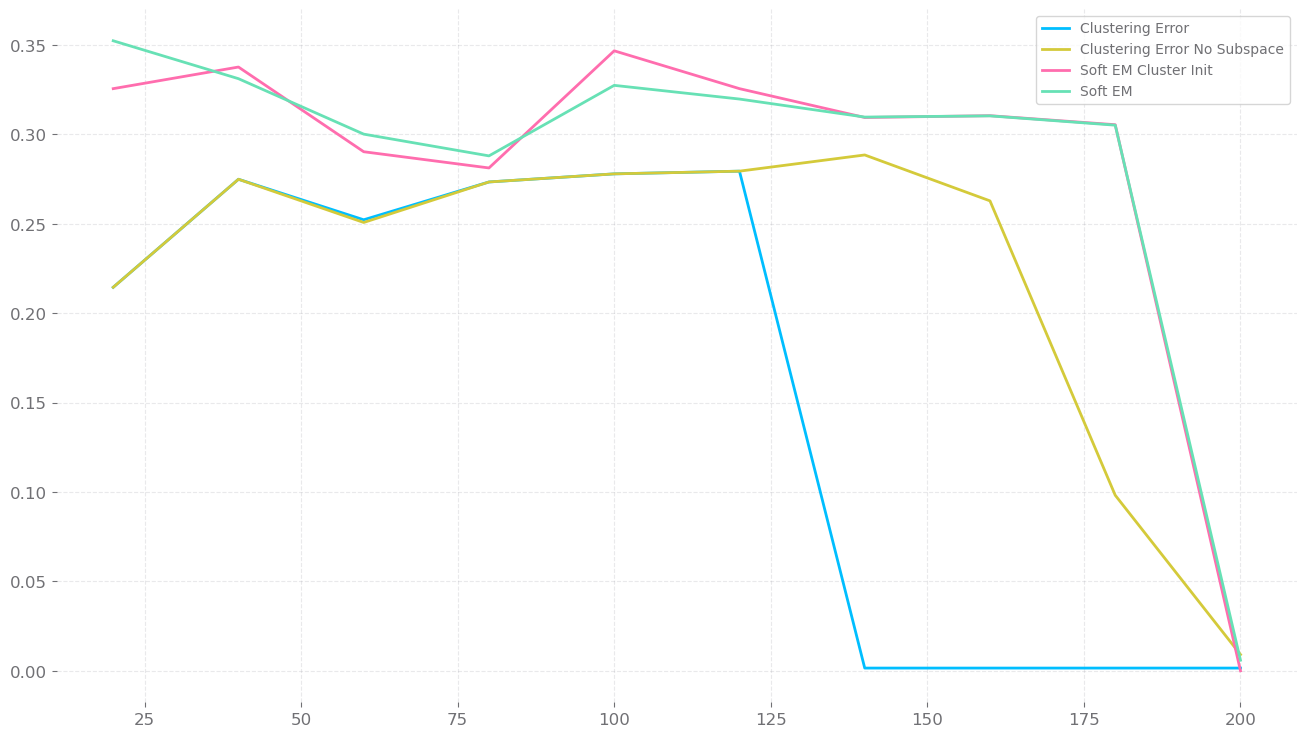

In [4]:
plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.array(clusterAccs), label='Clustering Error')
plt.plot(horizons, 1-np.array(clusterAccsNoProjs), label='Clustering Error No Subspace')
'''
plt.plot(horizons, 1-np.array(classAccs), label='Subspace Classification')
plt.plot(horizons, 1-np.array([np.max([np.mean(i[0]==labels), 
                  np.mean(i[0]!=labels)]) for i in hardClustEMs]),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.array([np.mean([np.max([np.mean(j.argmax(0)==labels), np.mean(j.argmax(0)!=labels)]) 
  for j in hardEMs[i][0]]) for i in range(len(hardEMs))]),
        label='Hard EM')
'''
plt.plot(horizons, 1-np.array([np.max([np.mean(np.argmax(i[0],0)==labels), 
                  np.mean(np.argmax(i[0],0)!=labels)]) for i in softClustEMs]),
         label='Soft EM Cluster Init')
plt.plot(horizons, 1-np.array([np.mean([np.max([np.mean(j.argmax(0)==labels), np.mean(j.argmax(0)!=labels)]) 
  for j in softEMs[i][0]]) for i in range(len(softEMs))]),
        label='Soft EM')
plt.legend()

In [85]:
expectclass, modelestimclass, loglikclass = em(maxapos, 
                            Phat_ksa, states, actions, 
                        nextstates, labels=labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, max_iter=100,
                                               permute=False, permutation=permutation,
                                               checkin=1, hard=True)

iteration 1 diff 219.14279581992716
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 2 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 3 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 4 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 5 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 6 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 7 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 8 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 9 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 10 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
log-likelihood: -158443.87642185992


In [117]:
Ptrunc = np.zeros((K, nStates, nActions, nStates))
for u in tqdm(range(K)):
    for s in range(nStates):
        for a in range(nActions):
            for sp in range(nStates):
                Ptrunc[u, idx_to_trunc(s), a, idx_to_trunc(sp)] += P.transpose(0,2,1,3)[u, s, a, sp]

100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


In [88]:
normprobs = np.exp(mleprobs-np.max(mleprobs))
regprobs = 0.8*(normprobs)/np.nansum(np.abs(normprobs), 0) + 0.1*np.ones(mleprobs.shape)
expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                            Phat_ksa, states, actions, 
                        nextstates, labels, 
                        K=2, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, permute=False, permutation=permutation, checkin=1, hard=False)

iteration 1 diff 902.6985444463013
992 992
accuracy: 0.8850806451612904
-886518.5876762507
iteration 2 diff 898.7744546241128
992 992
accuracy: 1.0
-158933.26282156003
iteration 3 diff 262.0420420306183
992 992
accuracy: 1.0
-156091.77859972478
iteration 4 diff 316.47410281703657
992 992
accuracy: 1.0
-156090.68229785652
iteration 5 diff 55.35555552864855
992 992
accuracy: 1.0
-156090.68229785652
iteration 6 diff 0.0
992 992
accuracy: 1.0
-156090.68229785652
iteration 7 diff 0.0
992 992
accuracy: 1.0
-156090.68229785652
iteration 8 diff 0.0
992 992
accuracy: 1.0
-156090.68229785652
iteration 9 diff 0.0
992 992
accuracy: 1.0
-156090.68229785652
iteration 10 diff 0.0
992 992
accuracy: 1.0
-156090.68229785652
log-likelihood: -156090.68229785652


In [89]:
unifs = np.random.uniform(size=len(dataset))
randlabsoft = np.vstack([unifs, 1-unifs])
randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
randlabsoft, randmodelsoft, loglikrandsoft = em(randlabsoft, randmodelsoft,
   states[sz:], actions[sz:], nextstates[sz:], labels[sz:], 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, min_iter = 20, reg = 0, permute=True, permutation=True, checkin=1, hard=False)

iteration 1 diff 303.67803261481635
662 662
accuracy: 0.6661631419939577
-106004.2150536633
iteration 2 diff 88.85210336160041
662 662
accuracy: 0.9516616314199395
-105923.98173374307
iteration 3 diff 226.18172385281557
662 662
accuracy: 0.9788519637462235
-103798.73280693352
iteration 4 diff 167.88232418890323
662 662
accuracy: 0.9879154078549849
-103492.02305564527
iteration 5 diff 185.17964475977345
662 662
accuracy: 0.9909365558912386
-103490.25558164774
iteration 6 diff 19.488909581139758
662 662
accuracy: 0.9924471299093656
-103482.78125795255
iteration 7 diff 11.302521796352703
662 662
accuracy: 0.9939577039274925
-103479.7842277346
iteration 8 diff 14.447802779639565
662 662
accuracy: 0.9954682779456193
-103494.53606567462
iteration 9 diff 7.523305447976231
662 662
accuracy: 0.9954682779456193
-103489.15595104265
iteration 10 diff 9.866920475853298
662 662
accuracy: 0.9969788519637462
-103493.5191028165
iteration 11 diff 4.059558400784289
662 662
accuracy: 0.9969788519637462
-1

In [ ]:
labelsemsoft = []
logliksemsoft = []
for i in tqdm(range(30)):
    unifs = np.random.uniform(size=len(dataset))
    randlabsoft = np.vstack([unifs, 1-unifs])
    randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
    randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
   states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
    labelsemsoft.append(randlabsoft)
    logliksemsoft.append(loglikrand)
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
            logliksemsoft)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')
plt.show()
plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
plt.show()

 77%|███████▋  | 23/30 [00:15<00:04,  1.62it/s]

100%|██████████| 30/30 [00:19<00:00,  1.55it/s]

0.9164463141025639
0.9213241185897436
0.9365985576923077


(array([ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

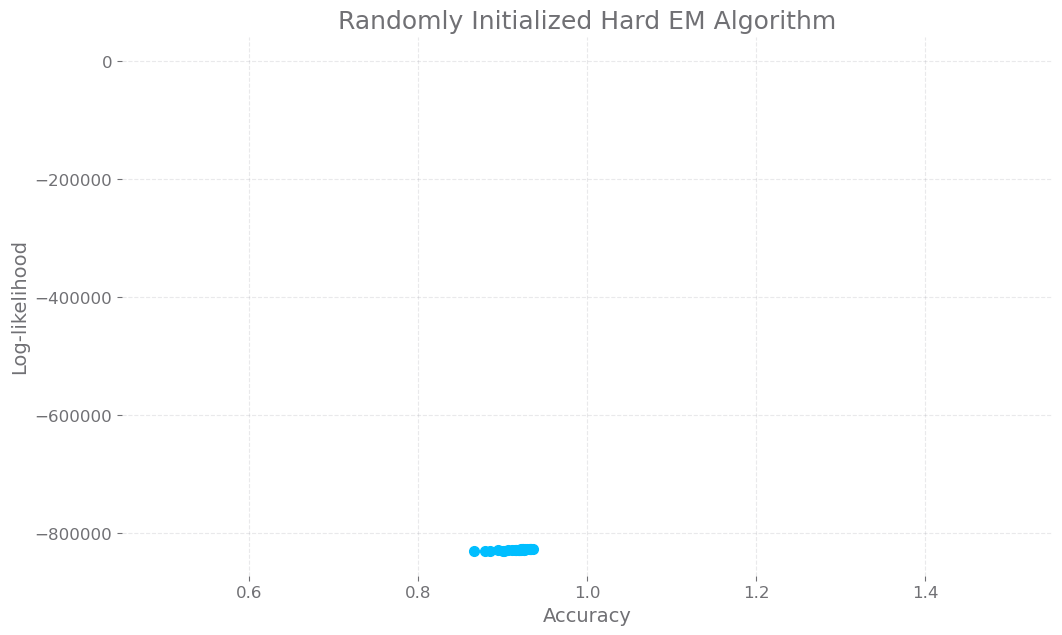

In [30]:
labelsem = []
logliksem = []
for i in tqdm(range(30)):
    randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
    randmodel = getModelEstim(randlabs, states, actions, nextstates,
                              K, nStates, nActions, hard=True)
    randlabs, randmodel, loglikrand = em(randlabs, randmodel,
       states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
    labelsem.append(randlabs)
    logliksem.append(loglikrand)
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Hard EM Algorithm')
plt.show()
plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem])
plt.show()